import pytorch

In [ ]:
import torch
import torchvision 
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import scipy.io

make sure we are connected to gpu

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Get Data from the StanfordCars dataset

In [ ]:
def get_stanfordCars_data():
    transform_train = transforms.Compose([
        transforms.Resize((256, 256)),
        # transforms.RandomCrop(256, padding=4, padding_mode='edge'),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize((256, 256)),
        # transforms.RandomCrop(256, padding=4, padding_mode='edge'),
        transforms.ToTensor(),
    ])
    trainset = torchvision.datasets.StanfordCars(root='./data', split='train', download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

    testset = torchvision.datasets.StanfordCars(root='./data', split='test', download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

    temp = scipy.io.loadmat('./data/stanford_cars/devkit/cars_meta.mat')
    temp = temp['class_names']
    n = temp.size
    classes = np.empty(shape=[n], dtype=object)
    for i in range(n):
      classes[i] = temp[0,i][0]
    return {'train':trainloader, 'test':testloader, 'classes':classes}

data = get_stanfordCars_data()

In [ ]:
print(data['train'].__dict__)
print(data['test'].__dict__)
print(len(data['classes']))

In [ ]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
# images = images[:8]

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['classes'][labels[j]] for j in range(8)))

flat = torch.flatten(images, 1)
print(images.size())
print(flat.size())

We will build a basic neural netword with SimpleNet

In [ ]:
class SimpleNet(nn.Module):
  def __init__(self, inputs=196608, hidden=512, outputs=196):
    super(SimpleNet, self).__init__()
    self.fc1 = nn.Linear(inputs, hidden)
    self.fc2 = nn.Linear(hidden, outputs)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x

We will not build a CNN

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        # Input 256x256x3 image
        # 16 filters
        # 3x3 filter size (they also have 3 channels)
        # stride 2 (downsampling by factor of 2)
        # Output image: 128x128x16
        self.conv1 = nn.Conv2d(3, 16, 3, stride=2, padding=1)

        # Input 128x128x16 image
        # 32 filters
        # 3x3x16 filter size (they also have 16 channels)
        # stride 2 (downsampling by factor of 2)
        # Output image: 64x64x32
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)


        # Exercise left to the reader
        # Output image: 32x32x64 -> 65536 neurons
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)

        self.fc1 = nn.Linear(65536, 196)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

Use Bacth Normalization to make training faster

In [ ]:
class Darknet64(nn.Module):
    def __init__(self):
        super(Darknet64, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)

        self.fc10 = nn.Linear(256, 196)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), kernel_size=2, stride=2)
        x = F.adaptive_avg_pool2d(x, 1)
        x = torch.flatten(x, 1)
        x = self.fc10(x)
        return x

Training function

In [ ]:
def train(net, dataloader, epochs=10, lr=0.01, momentum=0.9, decay=0.0, verbose=1):
  net.to(device)
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in gradient direction

        # print statistics
        losses.append(loss.item())
        sum_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, sum_loss / 100))
            sum_loss = 0.0
  return losses

Training our model with SimpleNet

In [ ]:
simple_net = SimpleNet()
simple_losses = train(simple_net, data['train'], epochs=5)

Training with CNN

In [ ]:
conv_net = ConvNet()
conv_losses = train(conv_net, data['train'])

[1,   100] loss: 5.282
[1,   200] loss: 5.277
[2,   100] loss: 5.188
[2,   200] loss: 5.164
[3,   100] loss: 4.978
[3,   200] loss: 4.996
[4,   100] loss: 4.731
[4,   200] loss: 4.768
[5,   100] loss: 4.070
[5,   200] loss: 4.247
[6,   100] loss: 2.466
[6,   200] loss: 2.773
[7,   100] loss: 1.486
[7,   200] loss: 1.575
[8,   100] loss: 0.828
[8,   200] loss: 0.962
[9,   100] loss: 0.510
[9,   200] loss: 0.493
[10,   100] loss: 0.264
[10,   200] loss: 0.317


Training with darknet

In [ ]:
dark_net = Darknet64()
dark_losses = train(dark_net, data['train'])

[1,   100] loss: 5.307
[1,   200] loss: 5.223
[2,   100] loss: 5.142
[2,   200] loss: 5.145
[3,   100] loss: 5.076
[3,   200] loss: 5.098
[4,   100] loss: 5.023
[4,   200] loss: 5.019
[5,   100] loss: 4.949
[5,   200] loss: 4.954
[6,   100] loss: 4.891
[6,   200] loss: 4.874
[7,   100] loss: 4.812
[7,   200] loss: 4.831
[8,   100] loss: 4.766
[8,   200] loss: 4.757
[9,   100] loss: 4.656
[9,   200] loss: 4.701
[10,   100] loss: 4.550
[10,   200] loss: 4.623


Training with resnet

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 196) # Reinitializes final layer, assigns random weights
resnet_losses = train(resnet, data['train'])

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


[1,   100] loss: 4.921
[1,   200] loss: 3.374
[2,   100] loss: 1.703
[2,   200] loss: 1.405
[3,   100] loss: 0.748
[3,   200] loss: 0.708
[4,   100] loss: 0.393
[4,   200] loss: 0.381
[5,   100] loss: 0.227
[5,   200] loss: 0.227
[6,   100] loss: 0.117
[6,   200] loss: 0.121
[7,   100] loss: 0.067
[7,   200] loss: 0.061
[8,   100] loss: 0.049
[8,   200] loss: 0.051
[9,   100] loss: 0.032
[9,   200] loss: 0.030
[10,   100] loss: 0.024
[10,   200] loss: 0.021


Plot graph to compare losses

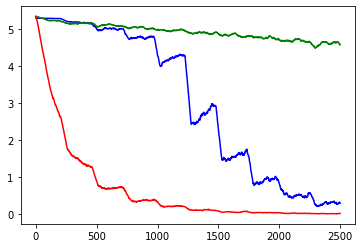

In [ ]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

plt.plot(smooth(simple_losses,50), 'r-')
plt.plot(smooth(conv_losses,50), 'b-')
plt.plot(smooth(dark_losses,50), 'k-')
plt.plot(smooth(resnet_losses,50), 'g-')

Testing the network

In [ ]:
dataiter = iter(data['test'])
images, labels = dataiter.next();

images = images[:4]
labels = labels[:4]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % data['classes'][labels[j]] for j in range(4)))
outputs = resnet(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % data['classes'][predicted[j]]
                              for j in range(4)))

In [ ]:
def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

Comparing the accuracy for our testing and training model.

In [ ]:
print("Current accuracy: %f" % accuracy(simple_net, data['train']))
print("Current accuracy: %f" % accuracy(simple_net, data['test']))

print("Training accuracy: %f" % accuracy(conv_net, data['train']))
print("Testing accuracy: %f" % accuracy(conv_net, data['test']))

print("Training accuracy: %f" % accuracy(dark_net, data['train']))
print("Testing accuracy: %f" % accuracy(dark_net, data['test']))

print("Training accuracy: %f" % accuracy(resnet, data['train']))
print("Testing accuracy: %f" % accuracy(resnet, data['test']))

Training accuracy: 0.971881
Testing accuracy: 0.027609
Training accuracy: 0.071586
Testing accuracy: 0.050989
Training accuracy: 0.996562
Testing accuracy: 0.819550
